In [20]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from skimage import measure

import os
import cv2
import numpy as np
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from skimage import measure

def load_lora_weights(model, lora_path):
    lora_state = torch.load(lora_path)
    for name, param in model.named_parameters():
        if name in lora_state:
            param.data = lora_state[name]
    return model

def get_points_from_image(image, num_points=5):
    # 转换为灰度图
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # 使用Canny边缘检测
    edges = cv2.Canny(gray, 100, 200)

    # 找到非零像素的坐标
    coords = np.column_stack(np.where(edges > 0))

    # 随机选择指定数量的点
    if len(coords) > num_points:
        points = coords[np.random.choice(len(coords), num_points, replace=False)]
    else:
        points = coords

    # 转换为[x, y]格式
    points = points[:, [1, 0]]

    return points

def inference(predictor, image_path, lora_path, device="cuda"):
    # 加载LoRA权重
    # predictor.model = load_lora_weights(predictor.model, lora_path)
    predictor.model.to(device)

    # 读取图像
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 获取点提示
    points = get_points_from_image(image)

    # 准备输入
    predictor.set_image(image)
    input_point = np.array(points)
    input_label = np.ones(input_point.shape[0])

    # 进行推理
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True
    )

    return image, masks, scores

def visualize_results(image, masks, scores):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.contour(mask, colors=['red', 'green', 'blue'][i % 3], alpha=0.7)
    plt.axis('off')
    plt.show()

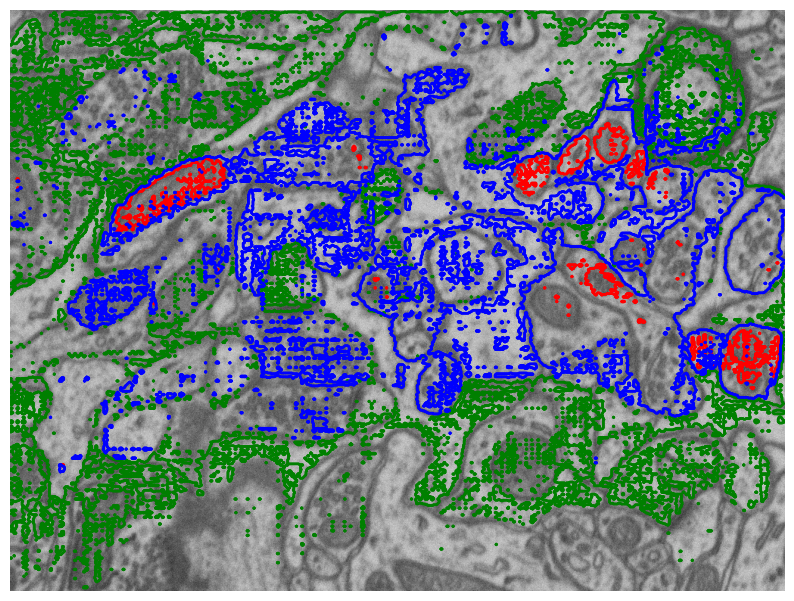

In [21]:
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sam2_checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
    model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
    lora_path = "sam2_lora_checkpoint_3000.pth"  # 假设这是最后一个检查点

    predictor = SAM2ImagePredictor(build_sam2(model_cfg, sam2_checkpoint, device=device))

    # 测试集路径
    test_images_dir = "dataset/Lucchi++/Test_In"

    # 随机选择一张测试图片
    test_image = np.random.choice(os.listdir(test_images_dir))
    test_image_path = os.path.join(test_images_dir, test_image)

    # 进行推理
    image, masks, scores = inference(predictor, test_image_path, lora_path, device)

    # 可视化结果
    visualize_results(image, masks, scores)